# Coletando dados do Twitter

In [3]:
# Importando os módulos 
import os
import tweepy as tw
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
import pandas as pd
import datetime
import json
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections
import nltk
from nltk.corpus import stopwords
from nltk import bigrams
import re
import networkx as nx
from textblob import TextBlob
from unidecode import unidecode
import schedule
import time
import warnings
import sqlite3

warnings.filterwarnings("ignore")
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

In [4]:
conn = sqlite3.connect('tweets.db')

In [5]:
tweets_df = pd.read_sql_query('''SELECT * FROM tweets''', conn)

In [6]:
tweets_df["texto"] = tweets_df["texto"].str.replace("#", "", regex=True)
tweets_df["texto"] = tweets_df["texto"].str.replace(r"http\S+", "", regex=True)
tweets_df["texto"] = tweets_df["texto"].str.replace("@", " ", regex=True)
tweets_df["texto"] = tweets_df["texto"].str.replace("_", " ", regex=True)
tweets_df["texto"] = tweets_df["texto"].str.replace("-", " ", regex=True)
tweets_df["texto"] = tweets_df["texto"].str.replace("+", " ", regex=True)
tweets_df["texto"] = tweets_df["texto"].str.replace("*", " ", regex=True)
tweets_df["texto"] = tweets_df["texto"].str.replace("&", " ", regex=True)
tweets_df["texto"] = tweets_df["texto"].str.replace(".", " ", regex=True)
tweets_df["texto"] = tweets_df["texto"].str.replace(",", " ", regex=True)

In [7]:
tweets_df

texto
0    Ah  minha vó testou positivo pro covid 😭 Mais ...
1     Cornetabfr1  MateusGuiaA  Elpoderosofogon Tra...
2    eu passo mal que n tem 1 mês que minha tia mor...
3    No desespero nem peguei máscara  Souza Aguiar ...
4     DCM online Milicianos e burros  Os idiotas es...
..                                                 ...
795  Na Índia  ladrão devolve 1 710 vacinas contra ...
796  📉🦠 Número de novos casos da Covid 19 cai 7% em...
797  Somos eu  você  todos nós  juntos contra a Cov...
798  Depois de atrair mais de 3 000 alunos  o MOOC ...
799   GraciNienov  BobjeffHD Voces  do PTB  tão foc...

[800 rows x 1 columns]

In [ ]:
# def remove_url(txt):
#     """Trocar as URLs encontradas em uma string por vazio.
#     (será removido a URL da string).
#     """
    
#     return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())
#     return " ".join(re.sub(r"http\S+", "", txt).split()).replace("#", "").replace("@", " ").replace("_", " ").replace("-", " ").replace("+", " ").replace("*", " ").replace("&", " ")


In [ ]:
#df = remove_url(str(df))

In [8]:
# Imprimindo os 5 primeiros tweets sem as URLs
tweets_df[:5]

texto
0  Ah  minha vó testou positivo pro covid 😭 Mais ...
1   Cornetabfr1  MateusGuiaA  Elpoderosofogon Tra...
2  eu passo mal que n tem 1 mês que minha tia mor...
3  No desespero nem peguei máscara  Souza Aguiar ...
4   DCM online Milicianos e burros  Os idiotas es...

In [9]:
# Criando uma lista contendo apenas letras minúsculas para cada tweet
words_in_tweet = [tweet.lower().split() for tweet in tweets_df['texto']]
words_in_tweet[:2]

[['ah',
  'minha',
  'vó',
  'testou',
  'positivo',
  'pro',
  'covid',
  '😭',
  'mais',
  'seguimos',
  'na',
  'fé',
  '🙏🙏🙏🙏🙏'],
 ['cornetabfr1',
  'mateusguiaa',
  'elpoderosofogon',
  'trabalho',
  'no',
  'coritiba:',
  'assumiu',
  'em',
  'setembro',
  'outubro',
  'pegou',
  'covid',
  'e',
  'ficou',
  '2…']]

In [10]:
# Lista de todas as palavras em tweets
tweets_df = list(itertools.chain(*words_in_tweet))

# Criando um contador
counts_no_urls = collections.Counter(tweets_df)

counts_no_urls.most_common(15)

[('covid', 595),
 ('de', 539),
 ('a', 304),
 ('o', 285),
 ('e', 262),
 ('que', 257),
 ('da', 206),
 ('em', 169),
 ('do', 164),
 ('19', 146),
 ('não', 142),
 ('com', 140),
 ('eu', 115),
 ('é', 108),
 ('no', 107)]

In [11]:
# Criando um Dataframe para as 15 palavras mais comuns
clean_tweets_no_urls = pd.DataFrame(counts_no_urls.most_common(15),
                             columns=['palavras', 'frequência'])

clean_tweets_no_urls.head(15)

palavras  frequência
0     covid         595
1        de         539
2         a         304
3         o         285
4         e         262
5       que         257
6        da         206
7        em         169
8        do         164
9        19         146
10      não         142
11      com         140
12       eu         115
13        é         108
14       no         107

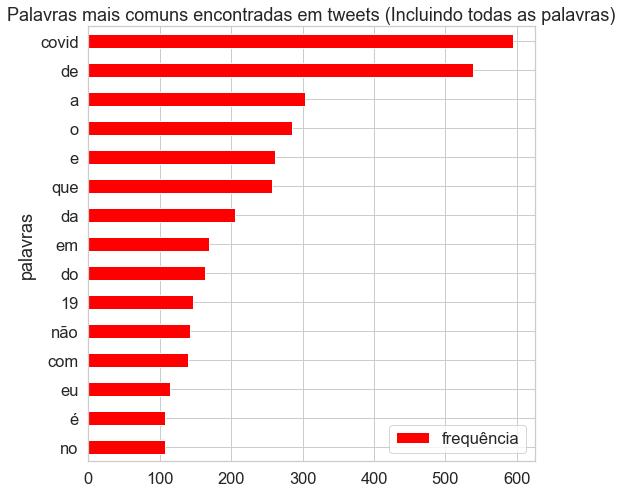

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))

# Gráfico de barras
clean_tweets_no_urls.sort_values(by='frequência').plot.barh(x='palavras',
                      y='frequência',
                      ax=ax,
                      color="red")

ax.set_title("Palavras mais comuns encontradas em tweets (Incluindo todas as palavras)")

plt.show()

In [13]:
# Remove stop-words, ou seja, palavras que não trazem informação útil (por exemplo: que; os; de; com; mas, etc)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
stop_words = set(stopwords.words('portuguese'))

# Visualizando alguns exemplos de stop-words
list(stop_words)[0:10]

['mas',
 'elas',
 'hajam',
 'muito',
 'pelo',
 'estejamos',
 'teus',
 'houveriam',
 'estivéssemos',
 'aquelas']

In [15]:
# palavras contidas no primeiro tweet coletado (sem filtrar)
words_in_tweet[0]

['ah',
 'minha',
 'vó',
 'testou',
 'positivo',
 'pro',
 'covid',
 '😭',
 'mais',
 'seguimos',
 'na',
 'fé',
 '🙏🙏🙏🙏🙏']

In [16]:
# Remove stop words de cada tweet da lista de palavras
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in words_in_tweet]

"""
é a mesma coisa que: 

for all_words in words_in_tweet:
    for a word in all_words:
"""

tweets_nsw[0]

['ah',
 'vó',
 'testou',
 'positivo',
 'pro',
 'covid',
 '😭',
 'seguimos',
 'fé',
 '🙏🙏🙏🙏🙏']

In [17]:
# Retornando as 15 palavras mais comuns, sem stop words

all_words_nsw = list(itertools.chain(*tweets_nsw))

counts_nsw = collections.Counter(all_words_nsw)

counts_nsw.most_common(15)

[('covid', 595),
 ('19', 146),
 ('contra', 57),
 ('pra', 54),
 ('casos', 48),
 ('cpi', 40),
 ('tá', 38),
 ('mortes', 37),
 ('bolsonaro', 36),
 ('vai', 36),
 ('|', 32),
 ('pandemia', 31),
 ('2', 31),
 ('pq', 30),
 ('vacina', 29)]

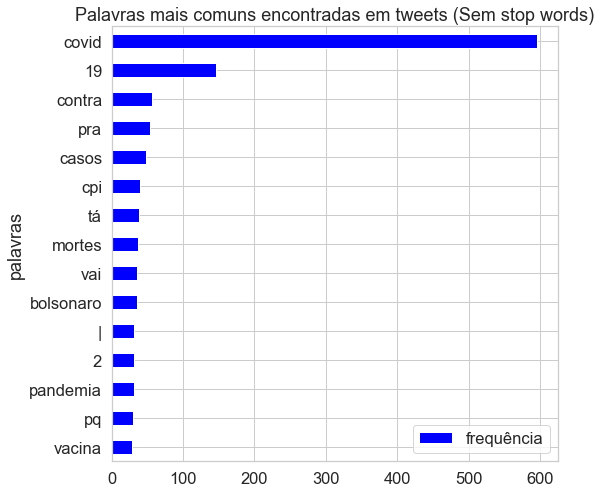

In [18]:
clean_tweets_nsw = pd.DataFrame(counts_nsw.most_common(15),
                             columns=['palavras', 'frequência'])

fig, ax = plt.subplots(figsize=(8, 8))

# Criando um gráfico de barras
clean_tweets_nsw.sort_values(by='frequência').plot.barh(x='palavras',
                      y='frequência',
                      ax=ax,
                      color="blue")

ax.set_title("Palavras mais comuns encontradas em tweets (Sem stop words)")

plt.show()

In [19]:
# Removendo coleções de palavras
collection_words = ['ser', 'manito', 'pra', 'tambm', 'dia',
                    'tbm', 'est', 'vacinao', 'd', 'm', 'totooxg', 
                    'sobre', 'sade', 'ter', 'ser', 'l', 'sobre', 
                    'i', 'q', 'ir', 'alem','além','.','n','tá']

tweets_nsw_nc = [[w for w in word if not w in collection_words]
                 for word in tweets_nsw]

In [20]:
# Retornando as 15 palavras mais comuns, com os filtros

all_words_nsw = list(itertools.chain(*tweets_nsw_nc))

counts_nsw = collections.Counter(all_words_nsw)

counts_nsw.most_common(15)

[('covid', 595),
 ('19', 146),
 ('contra', 57),
 ('casos', 48),
 ('cpi', 40),
 ('mortes', 37),
 ('bolsonaro', 36),
 ('vai', 36),
 ('|', 32),
 ('pandemia', 31),
 ('2', 31),
 ('pq', 30),
 ('vacina', 29),
 ('youtube', 28),
 ('brasil', 28)]

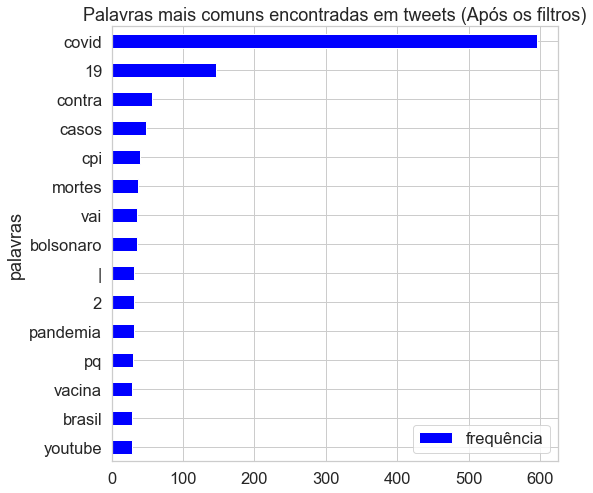

In [21]:
clean_tweets_nsw_nc = pd.DataFrame(counts_nsw.most_common(15),
                             columns=['palavras', 'frequência'])

fig, ax = plt.subplots(figsize=(8, 8))

# Criando um gráfico de barras
clean_tweets_nsw_nc.sort_values(by='frequência').plot.barh(x='palavras',
                      y='frequência',
                      ax=ax,
                      color="blue")

ax.set_title("Palavras mais comuns encontradas em tweets (Após os filtros)")

plt.show()

# Bigrama/Diagrama

In [22]:
"""
Um bigrama ou diagrama é uma sequência de dois elementos adjacentes de uma sequência de tokens,
que normalmente são letras, sílabas ou palavras. 
A distribuição de frequência de cada bigrama em uma string é comumente usada
para análises estatísticas simples de texto em muitas aplicações, 
incluindo linguística computacional, criptografia, reconhecimento de voz e assim por diante.
"""
# Criando uma lista de listas contendo bigramas em tweets
terms_bigram = [list(bigrams(tweet)) for tweet in tweets_nsw_nc]

# Print dos bigramas do primeiro tweet 
terms_bigram[0]

[('ah', 'vó'),
 ('vó', 'testou'),
 ('testou', 'positivo'),
 ('positivo', 'pro'),
 ('pro', 'covid'),
 ('covid', '😭'),
 ('😭', 'seguimos'),
 ('seguimos', 'fé'),
 ('fé', '🙏🙏🙏🙏🙏')]

In [23]:
# Lista dos bigramas em tweets filtrados
bigrams = list(itertools.chain(*terms_bigram))

# Criando um contador de palavras em bigramas filtrados
bigram_counts = collections.Counter(bigrams)

bigram_counts.most_common(20)

[(('covid', '19'), 146),
 (('contra', 'covid'), 54),
 (('cpi', 'covid'), 30),
 (('casos', 'covid'), 25),
 (('mortes', 'covid'), 20),
 (('covid', '19:'), 19),
 (('sexta', 'feira'), 17),
 (('novos', 'casos'), 15),
 (('pegou', 'covid'), 11),
 (('vídeos', 'bolsonaro'), 11),
 (('vacina', 'contra'), 11),
 (('4', 'vídeos'), 10),
 (('desinformação', 'covid'), 10),
 (('nesta', 'sexta'), 10),
 (('vacinas', 'contra'), 10),
 (('derruba', '4'), 9),
 (('|', 'g1'), 9),
 (('vacinação', 'contra'), 9),
 (('brasil', 'registra'), 9),
 (('registra', '2'), 9)]

In [24]:
# Criando um Dataframe
bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['bigrama', 'frequência'])

bigram_df

bigrama  frequência
0              (covid, 19)         146
1          (contra, covid)          54
2             (cpi, covid)          30
3           (casos, covid)          25
4          (mortes, covid)          20
5             (covid, 19:)          19
6           (sexta, feira)          17
7           (novos, casos)          15
8           (pegou, covid)          11
9      (vídeos, bolsonaro)          11
10        (vacina, contra)          11
11             (4, vídeos)          10
12  (desinformação, covid)          10
13          (nesta, sexta)          10
14       (vacinas, contra)          10
15            (derruba, 4)           9
16                 (|, g1)           9
17     (vacinação, contra)           9
18      (brasil, registra)           9
19           (registra, 2)           9

In [25]:
# Criando um dicionário dos bigramas e suas frequências
d = bigram_df.set_index('bigrama').T.to_dict('registros')


In [26]:
# Criando um grafo
G = nx.Graph()

# Criando conexões entre os nós
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))



In [27]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# Grafo
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Características do grafo
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

# Análise de sentimentos

In [28]:
"""
Usaremos o pacote TextBlob para calcular a polaridade dos valores individuais de tweets que falem sobre a COVID19.

Vamos começar criando objetos textblob, que atribui os valores de polaridade para os tweets.
Podemos identificar o valor da polaridade usando o atributo .polarity do objeto textblob.
"""

# Criando objetos textblob dos tweets
sentiment_objects = [TextBlob(tweet) for tweet in tweets_df]

sentiment_objects[0].polarity, sentiment_objects[0]

(0.0, TextBlob("ah"))

In [29]:
# Criando uma lista de valores de polaridade e texto do tweet
sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]

sentiment_values[4]

[0.0, 'positivo']

In [30]:
# Criando um Dataframe contendo os valores de polaridade e o texto dos tweets
sentiment_df = pd.DataFrame(sentiment_values, columns=["polaridade", "tweet"])

sentiment_df.head()

polaridade     tweet
0         0.0        ah
1         0.0     minha
2         0.0        vó
3         0.0    testou
4         0.0  positivo

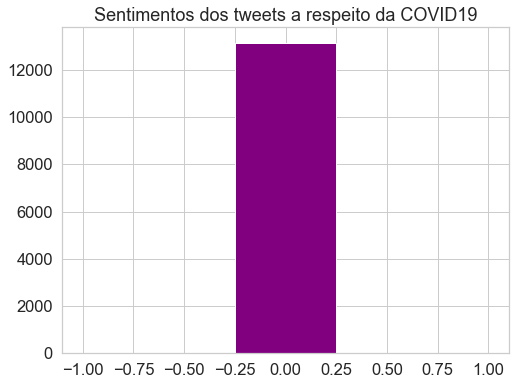

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))

# Criando um histograma dos valores da polaridade
sentiment_df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentimentos dos tweets a respeito da COVID19")
plt.show()

In [32]:
# Remove valores da polaridade igual a zero
sentiment_df = sentiment_df[sentiment_df.polaridade != 0]

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))

# Histograma com um break no zero
sentiment_df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentimentos dos tweets a respeito da COVID19")
plt.show()